In [133]:
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

PATH_TO_SEQS = 'test_data.gb'
SEPARATE_GENES = False #for gb
PATH_TO_RESULT = '../../figures'

#TODO: ~~add fasta parser~~ 
# ~~add strand check for gb~~
# ~~add global parsing (not separating by genes)~~
# ~~fix graphs~~
# add multiple files processing


In [128]:

skew_types = ['AT', 'AG', 'AC', 'TA', 'TG','TC', 'GT', 'GA', 'GC', 'CG', 'CA', 'CT']
    
def gb_parser(PATH_TO_GB, GENE_CONDITION):
    characteristics_list = ['Species', 'Taxonomy', 'Sequence', 'A', 'T','G', 'C']
    characteristics = {}
    for char in characteristics_list:
        characteristics[char] = 0
    df = pd.DataFrame(columns=characteristics_list)
    for entry in SeqIO.parse(PATH_TO_GB, 'genbank'):
        characteristics['Species'] = entry.annotations['organism']
        characteristics['Taxonomy'] = entry.annotations['taxonomy']
        if GENE_CONDITION == True:
            #checking for genes
            for feat in entry.features:
                if feat.type == 'CDS':
                    if 'gene' not in feat.qualifiers:
                        characteristics['Gene_name'] = 'NA'
                    else:
                        characteristics['Gene_name'] = ''.join(feat.qualifiers['gene'])
                    #checking strands
                    if feat.strand == 1:
                        characteristics['Sequence'] = feat.location.extract(entry).seq
                    else:
                        characteristics['Sequence'] = feat.location.extract(entry).seq.reverse_complement()
                    characteristics['A'] = characteristics['Sequence'].count('A')
                    characteristics['T'] = characteristics['Sequence'].count('T')
                    characteristics['G'] = characteristics['Sequence'].count('G')
                    characteristics['C'] = characteristics['Sequence'].count('C')
                    df = df.append(characteristics, ignore_index=True)
        else:
            characteristics['Sequence'] = entry.seq
            characteristics['A'] = characteristics['Sequence'].count('A')
            characteristics['T'] = characteristics['Sequence'].count('T')
            characteristics['G'] = characteristics['Sequence'].count('G')
            characteristics['C'] = characteristics['Sequence'].count('C')
            df = df.append(characteristics, ignore_index=True)
            
    for skew_type in skew_types:
        dividend = list(skew_type)[0]
        divisor = list(skew_type)[1]
        skew = (df[dividend] - df[divisor])/(df[dividend] + df[divisor])
        df = df.merge(skew.rename(f'{skew_type}skew'), left_index=True, right_index=True)
    return df

def fasta_parser(PATH_TO_FASTA):
    characteristics_list = ['Species ID', 'Sequence', 'A', 'T','G', 'C']
    characteristics = {}
    for char in characteristics_list:
        characteristics[char] = 0
    df = pd.DataFrame(columns=characteristics_list)
    for entry in SeqIO.parse(PATH_TO_FASTA, 'fasta'):
        characteristics['Species ID'] = entry.id
        characteristics['Sequence'] = entry.seq
        characteristics['A'] = characteristics['Sequence'].count('A')
        characteristics['T'] = characteristics['Sequence'].count('T')
        characteristics['G'] = characteristics['Sequence'].count('G')
        characteristics['C'] = characteristics['Sequence'].count('C')
        df = df.append(characteristics, ignore_index=True)
    for skew_type in skew_types:
        dividend = list(skew_type)[0]
        divisor = list(skew_type)[1]
        skew = (df[dividend] - df[divisor])/(df[dividend] + df[divisor])
        df = df.merge(skew.rename(f'{skew_type}skew'), left_index=True, right_index=True)
    return df

In [129]:

def plot_nucl_content(df):
    if 'Gene_name' in df.columns:
        fig, axes = plt.subplots(3, 4, sharey=True, figsize=(20,20))
        for row in range(3):
            for column in range(4):
                axes[row,column].set_xticklabels(axes[row,column].get_xticks(), rotation = 45) 
        sns.boxplot(data=df, ax=axes[0,0], x="Gene_name", y="ATskew")
        sns.boxplot(data=df, ax=axes[0,1], x="Gene_name", y="AGskew")
        sns.boxplot(data=df, ax=axes[0,2], x="Gene_name", y="ACskew")
        sns.boxplot(data=df, ax=axes[0,3], x="Gene_name", y="TAskew")
        sns.boxplot(data=df, ax=axes[1,0], x="Gene_name", y="TGskew")
        sns.boxplot(data=df, ax=axes[1,1], x="Gene_name", y="TCskew")
        sns.boxplot(data=df, ax=axes[1,2], x="Gene_name", y="GTskew")
        sns.boxplot(data=df, ax=axes[1,3], x="Gene_name", y="GAskew")
        sns.boxplot(data=df, ax=axes[2,0], x="Gene_name", y="GCskew")
        sns.boxplot(data=df, ax=axes[2,1], x="Gene_name", y="CGskew")
        sns.boxplot(data=df, ax=axes[2,2], x="Gene_name", y="CAskew")
        sns.boxplot(data=df, ax=axes[2,3], x="Gene_name", y="CTskew");
    else:
        #removing A, T, G, C because I'm lazy and/or stupid
        cropped_df = df.drop('A', axis=1)
        cropped_df = cropped_df.drop('T', axis=1)
        cropped_df = cropped_df.drop('G', axis=1)
        cropped_df = cropped_df.drop('C', axis=1)
        sns.boxplot(data=cropped_df)
        ax = sns.boxplot(data=cropped_df)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45);


In [134]:
if 'gb' in PATH_TO_SEQS:
    df = gb_parser(PATH_TO_SEQS, SEPARATE_GENES)
elif 'fasta' in PATH_TO_SEQS or 'fa' in PATH_TO_SEQS:
    df = fasta_parser(PATH_TO_SEQS)
else:
    print('Unsupported file type, you fucking donkey! Use either fasta or genbank!')

In [131]:
df

,Species,Taxonomy,Sequence,A,T,G,C,Gene_name,ATskew,AGskew,ACskew,TAskew,TGskew,TCskew,GTskew,GAskew,GCskew,CGskew,CAskew,CTskew
0,Periplaneta brunnea,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(A, T, G, A, C, C, A, A, C, A, A, T, T, C, A, ...",387,404,100,138,ND2,-0.021492,0.589322,0.474286,0.021492,0.603175,0.490775,-0.603175,-0.589322,-0.159664,0.159664,-0.474286,-0.490775
1,Periplaneta brunnea,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(A, C, T, C, T, G, C, A, A, C, G, A, T, G, A, ...",505,545,244,245,COX1,-0.038095,0.348465,0.346667,0.038095,0.381496,0.379747,-0.381496,-0.348465,-0.002045,0.002045,-0.346667,-0.379747
2,Periplaneta brunnea,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(A, T, G, A, C, A, A, C, A, T, G, A, G, C, T, ...",257,236,91,101,COX2,0.042596,0.477011,0.435754,-0.042596,0.443425,0.400593,-0.443425,-0.477011,-0.052083,0.052083,-0.435754,-0.400593
3,Periplaneta brunnea,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(A, T, C, C, C, A, C, A, A, A, T, A, A, T, A, ...",72,59,8,20,ATP8,0.099237,0.8,0.565217,-0.099237,0.761194,0.493671,-0.761194,-0.8,-0.428571,0.428571,-0.565217,-0.493671
4,Periplaneta brunnea,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(A, T, G, A, T, A, A, G, T, A, A, T, T, T, A, ...",257,246,75,103,ATP6,0.021869,0.548193,0.427778,-0.021869,0.53271,0.409742,-0.53271,-0.548193,-0.157303,0.157303,-0.427778,-0.409742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Periplaneta fuliginosa,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(T, T, A, T, A, A, T, C, A, A, A, A, T, G, A, ...",656,374,121,187,ND4,0.273786,0.688546,0.556346,-0.273786,0.511111,0.333333,-0.511111,-0.688546,-0.214286,0.214286,-0.556346,-0.333333
191,Periplaneta fuliginosa,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(T, T, A, A, C, A, T, T, G, T, A, A, C, A, T, ...",154,79,17,35,ND4L,0.321888,0.80117,0.62963,-0.321888,0.645833,0.385965,-0.645833,-0.80117,-0.346154,0.346154,-0.62963,-0.385965
192,Periplaneta fuliginosa,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(A, T, T, A, A, A, T, A, T, A, T, C, C, T, A, ...",221,183,39,57,ND6,0.094059,0.7,0.589928,-0.094059,0.648649,0.525,-0.648649,-0.7,-0.1875,0.1875,-0.589928,-0.525
193,Periplaneta fuliginosa,"[Eukaryota, Metazoa, Ecdysozoa, Arthropoda, He...","(A, T, G, A, A, T, A, A, A, C, C, T, A, T, A, ...",391,411,147,183,CYTB,-0.024938,0.453532,0.362369,0.024938,0.473118,0.383838,-0.473118,-0.453532,-0.109091,0.109091,-0.362369,-0.383838


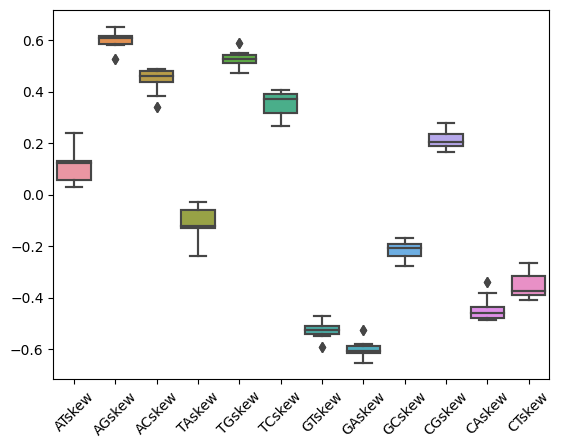

In [135]:
plot_nucl_content(df)